# Statistical Data Modeling

Some or most of you have probably taken some undergraduate- or graduate-level statistics courses. Unfortunately, the curricula for most introductory statisics courses are mostly focused on conducting **statistical hypothesis tests** as the primary means for interest: t-tests, chi-squared tests, analysis of variance, etc. Such tests seek to esimate whether groups or effects are "statistically significant", a concept that is poorly understood, and hence often misused, by most practioners. Even when interpreted correctly, statistical significance is a questionable goal for statistical inference, as it is of limited utility.

A far more powerful approach to statistical analysis involves building flexible **models** with the overarching aim of *estimating* quantities of interest. This section of the tutorial illustrates how to use Python to build statistical models of low to moderate difficulty from scratch, and use them to extract estimates and associated measures of uncertainty.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set some Pandas options
pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 25)

Estimation
==========

An recurring statistical problem is finding estimates of the relevant parameters that correspond to the distribution that best represents our data.

In **parametric** inference, we specify *a priori* a suitable distribution, then choose the parameters that best fit the data.

* e.g. $\mu$ and $\sigma^2$ in the case of the normal distribution

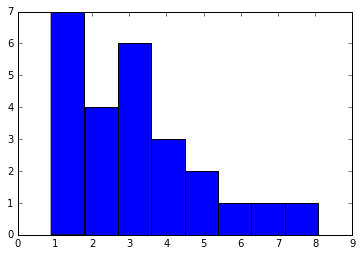

In [2]:
x = np.array([ 1.00201077,  1.58251956,  0.94515919,  6.48778002,  1.47764604,
        5.18847071,  4.21988095,  2.85971522,  3.40044437,  3.74907745,
        1.18065796,  3.74748775,  3.27328568,  3.19374927,  8.0726155 ,
        0.90326139,  2.34460034,  2.14199217,  3.27446744,  3.58872357,
        1.20611533,  2.16594393,  5.56610242,  4.66479977,  2.3573932 ])
_ = plt.hist(x, bins=8)

### Fitting data to probability distributions

We start with the problem of finding values for the parameters that provide the best fit between the model and the data, called point estimates. First, we need to define what we mean by ‘best fit’. There are two commonly used criteria:

* **Method of moments** chooses the parameters so that the sample moments (typically the sample mean and variance) match the theoretical moments of our chosen distribution.
* **Maximum likelihood** chooses the parameters to maximize the likelihood, which measures how likely it is to observe our given sample.

### Discrete Random Variables

$$X = \{0,1\}$$

$$Y = \{\ldots,-2,-1,0,1,2,\ldots\}$$

**Probability Mass Function**: 

For discrete $X$,

$$Pr(X=x) = f(x|\theta)$$

![Discrete variable](http://upload.wikimedia.org/wikipedia/commons/1/16/Poisson_pmf.svg)

***e.g. Poisson distribution***

The Poisson distribution models unbounded counts:

<div style="font-size: 150%;">  
$$Pr(X=x)=\frac{e^{-\lambda}\lambda^x}{x!}$$
</div>

* $X=\{0,1,2,\ldots\}$
* $\lambda > 0$

$$E(X) = \text{Var}(X) = \lambda$$

### Continuous Random Variables

$$X \in [0,1]$$

$$Y \in (-\infty, \infty)$$

**Probability Density Function**: 

For continuous $X$,

$$Pr(x \le X \le x + dx) = f(x|\theta)dx \, \text{ as } \, dx \rightarrow 0$$

![Continuous variable](http://upload.wikimedia.org/wikipedia/commons/e/ec/Exponential_pdf.svg)

***e.g. normal distribution***

<div style="font-size: 150%;">  
$$f(x) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left[-\frac{(x-\mu)^2}{2\sigma^2}\right]$$
</div>

* $X \in \mathbf{R}$
* $\mu \in \mathbf{R}$
* $\sigma>0$

$$\begin{align}E(X) &= \mu \cr
\text{Var}(X) &= \sigma^2 \end{align}$$

### Example: Nashville Precipitation

The dataset `nashville_precip.txt` contains [NOAA precipitation data for Nashville measured since 1871](http://bit.ly/nasvhville_precip_data). The gamma distribution is often a good fit to aggregated rainfall data, and will be our candidate distribution in this case.

In [3]:
precip = pd.read_table("data/nashville_precip.txt", index_col=0, na_values='NA', delim_whitespace=True)
precip.head()

       Jan   Feb   Mar    Apr   May   Jun   Jul   Aug   Sep   Oct   Nov   Dec
Year                                                                         
1871  2.76  4.58  5.01   4.13  3.30  2.98  1.58  2.36  0.95  1.31  2.13  1.65
1872  2.32  2.11  3.14   5.91  3.09  5.17  6.10  1.65  4.50  1.58  2.25  2.38
1873  2.96  7.14  4.11   3.59  6.31  4.20  4.63  2.36  1.81  4.28  4.36  5.94
1874  5.22  9.23  5.36  11.84  1.49  2.87  2.65  3.52  3.12  2.63  6.12  4.19
1875  6.15  3.06  8.14   4.22  1.73  5.63  8.12  1.60  3.79  1.25  5.46  4.30

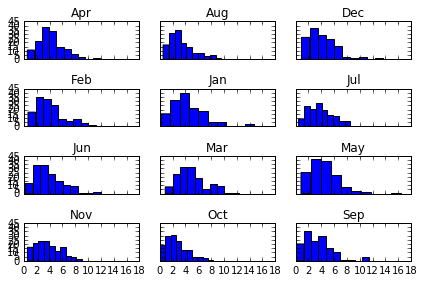

In [4]:
_ = precip.hist(sharex=True, sharey=True, grid=False)
plt.tight_layout()

The first step is recognixing what sort of distribution to fit our data to. A couple of observations:

1. The data are skewed, with a longer tail to the right than to the left
2. The data are positive-valued, since they are measuring rainfall
3. The data are continuous

There are a few possible choices, but one suitable alternative is the **gamma distribution**:

<div style="font-size: 150%;">  
$$x \sim \text{Gamma}(\alpha, \beta) = \frac{\beta^{\alpha}x^{\alpha-1}e^{-\beta x}}{\Gamma(\alpha)}$$
</div>

![gamma](http://upload.wikimedia.org/wikipedia/commons/thumb/e/e6/Gamma_distribution_pdf.svg/500px-Gamma_distribution_pdf.svg.png)

The ***method of moments*** simply assigns the empirical mean and variance to their theoretical counterparts, so that we can solve for the parameters.

So, for the gamma distribution, the mean and variance are:

<div style="font-size: 150%;">  
$$ \hat{\mu} = \bar{X} = \alpha \beta $$
$$ \hat{\sigma}^2 = S^2 = \alpha \beta^2 $$
</div>

So, if we solve for these parameters, we can use a gamma distribution to describe our data:

<div style="font-size: 150%;">  
$$ \alpha = \frac{\bar{X}^2}{S^2}, \, \beta = \frac{S^2}{\bar{X}} $$
</div>

Let's deal with the missing value in the October data. Given what we are trying to do, it is most sensible to fill in the missing value with the average of the available values.

In [5]:
precip.fillna(value={'Oct': precip.Oct.mean()}, inplace=True)

        Jan    Feb   Mar    Apr    May   Jun   Jul   Aug    Sep   Oct   Nov  \
Year                                                                          
1871   2.76   4.58  5.01   4.13   3.30  2.98  1.58  2.36   0.95  1.31  2.13   
1872   2.32   2.11  3.14   5.91   3.09  5.17  6.10  1.65   4.50  1.58  2.25   
1873   2.96   7.14  4.11   3.59   6.31  4.20  4.63  2.36   1.81  4.28  4.36   
1874   5.22   9.23  5.36  11.84   1.49  2.87  2.65  3.52   3.12  2.63  6.12   
1875   6.15   3.06  8.14   4.22   1.73  5.63  8.12  1.60   3.79  1.25  5.46   
1876   6.41   2.22  5.28   3.62   3.40  5.65  7.15  5.77   2.52  2.68  1.26   
1877   4.05   1.06  4.98   9.47   1.25  6.02  3.25  4.16   5.40  2.61  4.93   
1878   3.34   2.10  3.48   6.88   2.33  3.28  9.43  5.02   1.28  2.17  3.20   
1879   6.32   3.13  3.81   2.88   2.88  2.50  8.47  4.62   5.18  2.90  5.85   
1880   3.74  12.37  8.16   5.26   4.13  3.97  5.69  2.22   5.39  7.24  5.77   
1881   3.54   5.48  2.79   5.12   3.67  3.70  0.86  

Now, let's calculate the sample moments of interest, the means and variances by month:

In [6]:
precip_mean = precip.mean()
precip_mean

Jan    4.523688
Feb    4.097801
Mar    4.977589
Apr    4.204468
May    4.325674
Jun    3.873475
Jul    3.895461
Aug    3.367305
Sep    3.377660
Oct    2.610500
Nov    3.685887
Dec    4.176241
dtype: float64

In [7]:
precip_var = precip.var()
precip_var

Jan    6.928862
Feb    5.516660
Mar    5.365444
Apr    4.117096
May    5.306409
Jun    5.033206
Jul    3.777012
Aug    3.779876
Sep    4.940099
Oct    2.741659
Nov    3.679274
Dec    5.418022
dtype: float64

We then use these moments to estimate $\alpha$ and $\beta$ for each month:

In [8]:
alpha_mom = precip_mean ** 2 / precip_var
beta_mom = precip_var / precip_mean

In [9]:
alpha_mom, beta_mom

(Jan    2.953407
 Feb    3.043866
 Mar    4.617770
 Apr    4.293694
 May    3.526199
 Jun    2.980965
 Jul    4.017624
 Aug    2.999766
 Sep    2.309383
 Oct    2.485616
 Nov    3.692511
 Dec    3.219070
 dtype: float64, Jan    1.531684
 Feb    1.346249
 Mar    1.077920
 Apr    0.979219
 May    1.226724
 Jun    1.299403
 Jul    0.969593
 Aug    1.122522
 Sep    1.462581
 Oct    1.050243
 Nov    0.998206
 Dec    1.297344
 dtype: float64)

We can use the `gamma.pdf` function in `scipy.stats.distributions` to plot the ditribtuions implied by the calculated alphas and betas. For example, here is January:

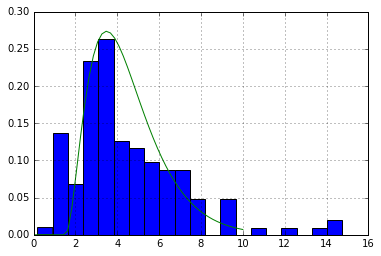

In [10]:
from scipy.stats.distributions import gamma

precip.Jan.hist(normed=True, bins=20)
plt.plot(np.linspace(0, 10), gamma.pdf(np.linspace(0, 10), alpha_mom[0], beta_mom[0]))

Looping over all months, we can create a grid of plots for the distribution of rainfall, using the gamma distribution:

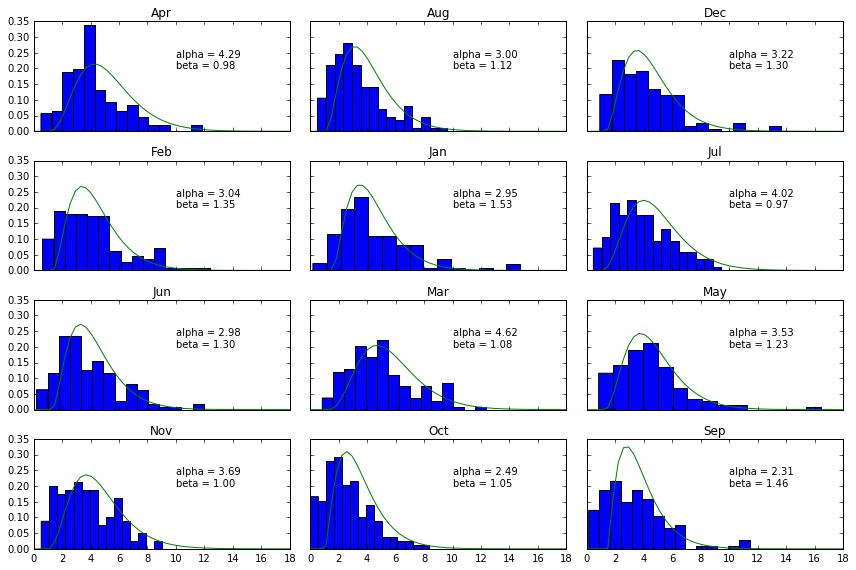

In [11]:
axs = precip.hist(normed=True, figsize=(12, 8), sharex=True, sharey=True, bins=15, grid=False)

for ax in axs.ravel():
    
    # Get month
    m = ax.get_title()
    
    # Plot fitted distribution
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, gamma.pdf(x, alpha_mom[m], beta_mom[m]))
    
    # Annotate with parameter estimates
    label = 'alpha = {0:.2f}\nbeta = {1:.2f}'.format(alpha_mom[m], beta_mom[m])
    ax.annotate(label, xy=(10, 0.2))
    
plt.tight_layout()

Maximum Likelihood
==================

**Maximum likelihood** (ML) fitting is usually more work than the method of moments, but it is preferred as the resulting estimator is known to have good theoretical properties. 

There is a ton of theory regarding ML. We will restrict ourselves to the mechanics here.

Say we have some data $y = y_1,y_2,\ldots,y_n$ that is distributed according to some distribution:

<div style="font-size: 120%;">  
$$Pr(Y_i=y_i | \theta)$$
</div>

Here, for example, is a **Poisson distribution** that describes the distribution of some discrete variables, typically *counts*: 

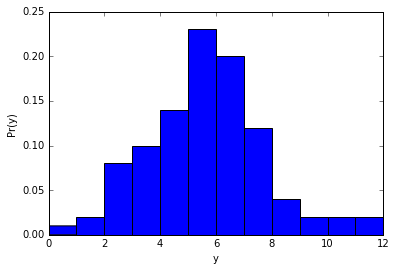

In [12]:
y = np.random.poisson(5, size=100)
plt.hist(y, bins=12, normed=True)
plt.xlabel('y'); plt.ylabel('Pr(y)')

The product $\prod_{i=1}^n Pr(y_i | \theta)$ gives us a measure of how **likely** it is to observe values $y_1,\ldots,y_n$ given the parameters $\theta$. Maximum likelihood fitting consists of choosing the appropriate function $l= Pr(Y|\theta)$ to maximize for a given set of observations. We call this function the *likelihood function*, because it is a measure of how likely the observations are if the model is true.

> Given these data, how likely is this model?

In the above model, the data were drawn from a Poisson distribution with parameter $\lambda =5$.

$$L(y|\lambda=5) = \frac{e^{-5} 5^y}{y!}$$

So, for any given value of $y$, we can calculate its likelihood:

In [13]:
poisson_like = lambda x, lam: np.exp(-lam) * (lam**x) / (np.arange(x)+1).prod()

lam = 6
value = 10
poisson_like(value, lam)

0.041303093412337726

In [14]:
np.sum(poisson_like(yi, lam) for yi in y)

12.381477861506735

In [15]:
lam = 8
np.sum(poisson_like(yi, lam) for yi in y)

8.5294017287503809

We can plot the likelihood function for any value of the parameter(s):

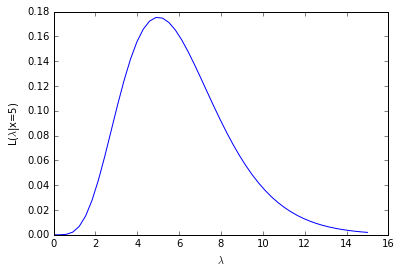

In [16]:
lambdas = np.linspace(0,15)
x = 5
plt.plot(lambdas, [poisson_like(x, l) for l in lambdas])
plt.xlabel('$\lambda$')
plt.ylabel('L($\lambda$|x={0})'.format(x))

How is the likelihood function different than the probability distribution function (PDF)? The likelihood is a function of the parameter(s) *given the data*, whereas the PDF returns the probability of data given a particular parameter value. Here is the PDF of the Poisson for $\lambda=5$.

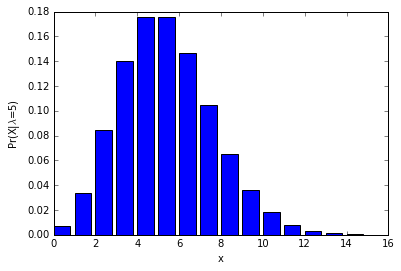

In [17]:
lam = 5
xvals = np.arange(15)
plt.bar(xvals, [poisson_like(x, lam) for x in xvals])
plt.xlabel('x')
plt.ylabel('Pr(X|$\lambda$=5)')

Why are we interested in the likelihood function? 

A reasonable estimate of the true, unknown value for the parameter is one which **maximizes the likelihood function**. So, inference is reduced to an optimization problem.

Going back to the rainfall data, if we are using a gamma distribution we need to maximize:

$$\begin{align}l(\alpha,\beta) &= \sum_{i=1}^n \log[\beta^{\alpha} x^{\alpha-1} e^{-x/\beta}\Gamma(\alpha)^{-1}] \cr 
&= n[(\alpha-1)\overline{\log(x)} - \bar{x}\beta + \alpha\log(\beta) - \log\Gamma(\alpha)]\end{align}$$

(*Its usually easier to work in the log scale*)

where $n = 2012 − 1871 = 141$ and the bar indicates an average over all *i*. We choose $\alpha$ and $\beta$ to maximize $l(\alpha,\beta)$.

Notice $l$ is infinite if any $x$ is zero. We do not have any zeros, but we do have an NA value for one of the October data, which we dealt with above.

### Finding the MLE

To find the maximum of any function, we typically take the *derivative* with respect to the variable to be maximized, set it to zero and solve for that variable. 

$$\frac{\partial l(\alpha,\beta)}{\partial \beta} = n\left(\frac{\alpha}{\beta} - \bar{x}\right) = 0$$

Which can be solved as $\beta = \alpha/\bar{x}$. However, plugging this into the derivative with respect to $\alpha$ yields:

$$\frac{\partial l(\alpha,\beta)}{\partial \alpha} = \log(\alpha) + \overline{\log(x)} - \log(\bar{x}) - \frac{\Gamma(\alpha)'}{\Gamma(\alpha)} = 0$$

This has no closed form solution. We must use ***numerical optimization***!

Numerical optimization alogarithms take an initial "guess" at the solution, and iteratively improve the guess until it gets "close enough" to the answer.

Here, we will use Newton-Raphson algorithm:

<div style="font-size: 120%;">  
$$x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)}$$
</div>

Which is available to us via SciPy:

In [18]:
from scipy.optimize import newton

Here is a graphical example of how Newtone-Raphson converges on a solution, using an arbitrary function:

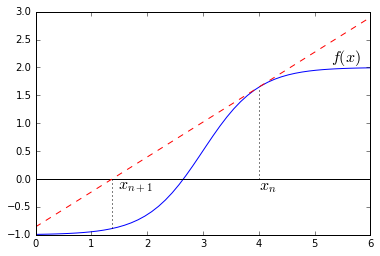

In [19]:
# some function
func = lambda x: 3./(1 + 400*np.exp(-2*x)) - 1
xvals = np.linspace(0, 6)
plt.plot(xvals, func(xvals))
plt.text(5.3, 2.1, '$f(x)$', fontsize=16)
# zero line
plt.plot([0,6], [0,0], 'k-')
# value at step n
plt.plot([4,4], [0,func(4)], 'k:')
plt.text(4, -.2, '$x_n$', fontsize=16)
# tangent line
tanline = lambda x: -0.858 + 0.626*x
plt.plot(xvals, tanline(xvals), 'r--')
# point at step n+1
xprime = 0.858/0.626
plt.plot([xprime, xprime], [tanline(xprime), func(xprime)], 'k:')
plt.text(xprime+.1, -.2, '$x_{n+1}$', fontsize=16)

To apply the Newton-Raphson algorithm, we need a function that returns a vector containing the **first and second derivatives** of the function with respect to the variable of interest. In our case, this is:

In [20]:
from scipy.special import psi, polygamma

dlgamma = lambda m, log_mean, mean_log: np.log(m) - psi(m) - log_mean + mean_log
dl2gamma = lambda m, *args: 1./m - polygamma(1, m)

where `log_mean` and `mean_log` are $\log{\bar{x}}$ and $\overline{\log(x)}$, respectively. `psi` and `polygamma` are complex functions of the Gamma function that result when you take first and second derivatives of that function.

In [21]:
# Calculate statistics
log_mean = precip.mean().apply(np.log)
mean_log = precip.apply(np.log).mean()

Time to optimize!

In [22]:
# Alpha MLE for December
alpha_mle = newton(dlgamma, 2, dl2gamma, args=(log_mean[-1], mean_log[-1]))
alpha_mle

3.5189679152399647

And now plug this back into the solution for beta:

<div style="font-size: 120%;">  
$$ \beta  = \frac{\alpha}{\bar{X}} $$
</div>

In [23]:
beta_mle = alpha_mle/precip.mean()[-1]
beta_mle

0.84261607548413797

We can compare the fit of the estimates derived from MLE to those from the method of moments:

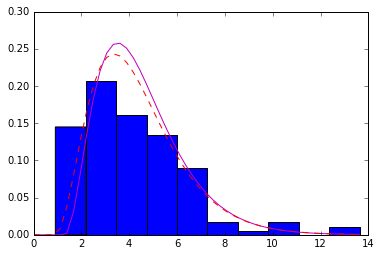

In [24]:
dec = precip.Dec
dec.hist(normed=True, bins=10, grid=False)
x = np.linspace(0, dec.max())
plt.plot(x, gamma.pdf(x, alpha_mom[-1], beta_mom[-1]), 'm-')
plt.plot(x, gamma.pdf(x, alpha_mle, beta_mle), 'r--')

For some common distributions, SciPy includes methods for fitting via MLE:

In [25]:
from scipy.stats import gamma

gamma.fit(precip.Dec)

(2.2427517753152308, 0.65494604470188622, 1.570073932063466)

This fit is not directly comparable to our estimates, however, because SciPy's `gamma.fit` method fits an odd 3-parameter version of the gamma distribution.

### Example: truncated distribution

Suppose that we observe $Y$ truncated below at $a$ (where $a$ is known). If $X$ is the distribution of our observation, then:

$$ P(X \le x) = P(Y \le x|Y \gt a) = \frac{P(a \lt Y \le x)}{P(Y \gt a)}$$

(so, $Y$ is the original variable and $X$ is the truncated variable) 

Then X has the density:

$$f_X(x) = \frac{f_Y (x)}{1−F_Y (a)} \, \text{for} \, x \gt a$$ 

Suppose $Y \sim N(\mu, \sigma^2)$ and $x_1,\ldots,x_n$ are independent observations of $X$. We can use maximum likelihood to find $\mu$ and $\sigma$. 

First, we can simulate a truncated distribution using a `while` statement to eliminate samples that are outside the support of the truncated distribution.

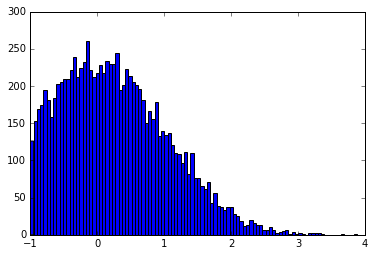

In [26]:
x = np.random.normal(size=10000)
a = -1
x_small = x < a
while x_small.sum():
    x[x_small] = np.random.normal(size=x_small.sum())
    x_small = x < a
    
_ = plt.hist(x, bins=100)

We can construct a log likelihood for this function using the conditional form:

$$f_X(x) = \frac{f_Y (x)}{1−F_Y (a)} \, \text{for} \, x \gt a$$ 

In [27]:
from scipy.stats.distributions import norm

trunc_norm = lambda theta, a, x: -(np.log(norm.pdf(x, theta[0], theta[1])) - 
                                      np.log(1 - norm.cdf(a, theta[0], theta[1]))).sum()

For this example, we will use another optimization algorithm, the **Nelder-Mead simplex algorithm**. It has a couple of advantages: 

- it does not require derivatives
- it can optimize (minimize) a vector of parameters

SciPy implements this algorithm in its `fmin` function:

In [28]:
from scipy.optimize import fmin

fmin(trunc_norm, np.array([1,2]), args=(-1, x))

Optimization terminated successfully.
         Current function value: 10963.011126
         Iterations: 44
         Function evaluations: 84


array([-0.00605384,  0.99392973])

In general, simulating data is a terrific way of testing your model before using it with real data.

### Kernel density estimates

In some instances, we may not be interested in the parameters of a particular distribution of data, but just a smoothed representation of the data at hand. In this case, we can estimate the disribution *non-parametrically* (i.e. making no assumptions about the form of the underlying distribution) using kernel density estimation.

In [29]:
# Some random data
y = np.random.random(15) * 10
y

array([ 8.84168421,  7.12184783,  5.45366998,  9.2764185 ,  3.79417326,
        4.49237422,  7.5249511 ,  3.97201941,  2.66241152,  0.51432975,
        8.17177388,  0.42905086,  4.53439293,  5.71380599,  6.71257462])

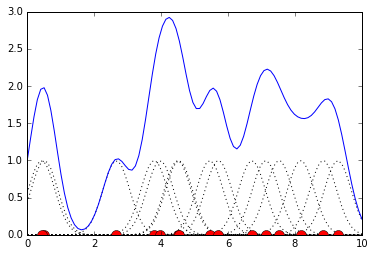

In [30]:
x = np.linspace(0, 10, 100)
# Smoothing parameter
s = 0.4
# Calculate the kernels
kernels = np.transpose([norm.pdf(x, yi, s) for yi in y])
plt.plot(x, kernels, 'k:')
plt.plot(x, kernels.sum(1))
plt.plot(y, np.zeros(len(y)), 'ro', ms=10)

SciPy implements a Gaussian KDE that automatically chooses an appropriate bandwidth. Let's create a bi-modal distribution of data that is not easily summarized by a parametric distribution:

In [31]:
# Create a bi-modal distribution with a mixture of Normals.
x1 = np.random.normal(0, 3, 50)
x2 = np.random.normal(4, 1, 50)

# Append by row
x = np.r_[x1, x2]

(array([ 0.00999892,  0.01499837,  0.02499729,  0.06499295,  0.06499295,
         0.05999349,  0.20997723,  0.04999458]),
 array([-9.30805315, -7.30783623, -5.30761931, -3.30740239, -1.30718547,
         0.69303145,  2.69324838,  4.6934653 ,  6.69368222]),
 <a list of 8 Patch objects>)

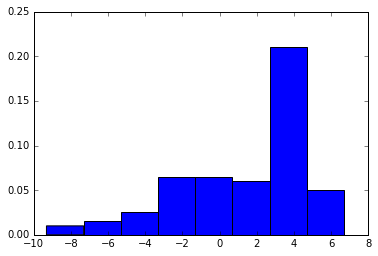

In [32]:
plt.hist(x, bins=8, normed=True)

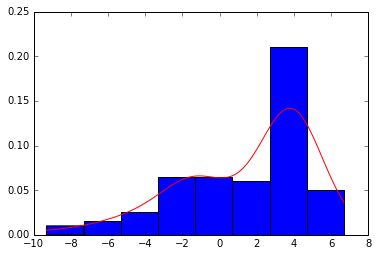

In [34]:
from scipy.stats import kde

density = kde.gaussian_kde(x)
xgrid = np.linspace(x.min(), x.max(), 100)
plt.hist(x, bins=8, normed=True)
plt.plot(xgrid, density(xgrid), 'r-')

### Exercise: Cervical dystonia analysis

Recall the cervical dystonia database, which is a clinical trial of botulinum toxin type B (BotB) for patients with cervical dystonia from nine U.S. sites. The response variable is measurements on the Toronto Western Spasmodic Torticollis Rating Scale (TWSTRS), measuring severity, pain, and disability of cervical dystonia (high scores mean more impairment). One way to check the efficacy of the treatment is to compare the distribution of TWSTRS for control and treatment patients at the end of the study.

Use the method of moments or MLE to calculate the mean and variance of TWSTRS at week 16 for one of the treatments and the control group. Assume that the distribution of the `twstrs` variable is normal:

$$f(x \mid \mu, \sigma^2) = \sqrt{\frac{1}{2\pi\sigma^2}} \exp\left\{ -\frac{1}{2} \frac{(x-\mu)^2}{\sigma^2} \right\}$$

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11343d5f8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x113605ac8>]], dtype=object)

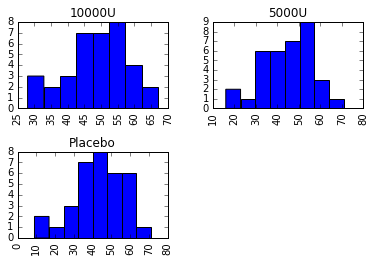

In [35]:
cdystonia = pd.read_csv("data/cdystonia.csv")
cdystonia[cdystonia.obs==6].hist(column='twstrs', by=cdystonia.treat, bins=8)

In [36]:
# Write your answer here

## Regression models

A general, primary goal of many statistical data analysis tasks is to relate the influence of one variable on another. For example, we may wish to know how different medical interventions influence the incidence or duration of disease, or perhaps a how baseball player's performance varies as a function of age.

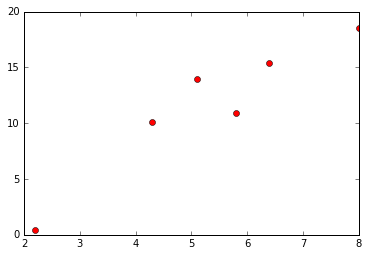

In [37]:
x = np.array([2.2, 4.3, 5.1, 5.8, 6.4, 8.0])
y = np.array([0.4, 10.1, 14.0, 10.9, 15.4, 18.5])
plt.plot(x,y,'ro')

We can build a model to characterize the relationship between $X$ and $Y$, recognizing that additional factors other than $X$ (the ones we have measured or are interested in) may influence the response variable $Y$.

<div style="font-size: 150%;">  
$y_i = f(x_i) + \epsilon_i$
</div>

where $f$ is some function, for example a linear function:

<div style="font-size: 150%;">  
$y_i = \beta_0 + \beta_1 x_i + \epsilon_i$
</div>

and $\epsilon_i$ accounts for the difference between the observed response $y_i$ and its prediction from the model $\hat{y_i} = \beta_0 + \beta_1 x_i$. This is sometimes referred to as **process uncertainty**.

We would like to select $\beta_0, \beta_1$ so that the difference between the predictions and the observations is zero, but this is not usually possible. Instead, we choose a reasonable criterion: ***the smallest sum of the squared differences between $\hat{y}$ and $y$***.

<div style="font-size: 120%;">  
$$R^2 = \sum_i (y_i - [\beta_0 + \beta_1 x_i])^2 = \sum_i \epsilon_i^2 $$  
</div>

Squaring serves two purposes: (1) to prevent positive and negative values from cancelling each other out and (2) to strongly penalize large deviations. Whether the latter is a good thing or not depends on the goals of the analysis.

In other words, we will select the parameters that minimize the squared error of the model.

In [38]:
ss = lambda theta, x, y: np.sum((y - theta[0] - theta[1]*x) ** 2)

In [39]:
ss([0,1],x,y)

333.35000000000002

In [40]:
b0,b1 = fmin(ss, [0,1], args=(x,y))
b0,b1

Optimization terminated successfully.
         Current function value: 21.375000
         Iterations: 79
         Function evaluations: 153


(-4.3500136038870876, 3.0000002915386412)

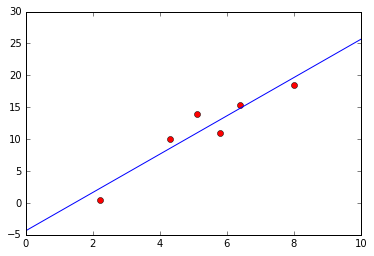

In [41]:
plt.plot(x, y, 'ro')
plt.plot([0,10], [b0, b0+b1*10])

(0, 20)

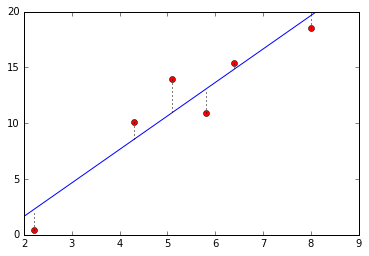

In [42]:
plt.plot(x, y, 'ro')
plt.plot([0,10], [b0, b0+b1*10])
for xi, yi in zip(x,y):
    plt.plot([xi]*2, [yi, b0+b1*xi], 'k:')
plt.xlim(2, 9); plt.ylim(0, 20)

Minimizing the sum of squares is not the only criterion we can use; it is just a very popular (and successful) one. For example, we can try to minimize the sum of absolute differences:

In [43]:
sabs = lambda theta, x, y: np.sum(np.abs(y - theta[0] - theta[1]*x))
b0,b1 = fmin(sabs, [0,1], args=(x,y))
print b0,b1
plt.plot(x, y, 'ro')
plt.plot([0,10], [b0, b0+b1*10])

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-43-485ba20decc9>, line 3)

We are not restricted to a straight-line regression model; we can represent a curved relationship between our variables by introducing **polynomial** terms. For example, a cubic model:

<div style="font-size: 150%;">  
$y_i = \beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \epsilon_i$
</div>

In [44]:
ss2 = lambda theta, x, y: np.sum((y - theta[0] - theta[1]*x - theta[2]*(x**2)) ** 2)
b0,b1,b2 = fmin(ss2, [1,1,-1], args=(x,y))
print b0,b1,b2
plt.plot(x, y, 'ro')
xvals = np.linspace(0, 10, 100)
plt.plot(xvals, b0 + b1*xvals + b2*(xvals**2))

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-44-42c64ce59a5e>, line 3)

Although polynomial model characterizes a nonlinear relationship, it is a linear problem in terms of estimation. That is, the regression model $f(y | x)$ is linear in the parameters.

For some data, it may be reasonable to consider polynomials of order>2. For example, consider the relationship between the number of home runs a baseball player hits and the number of runs batted in (RBI) they accumulate; clearly, the relationship is positive, but we may not expect a linear relationship.

Optimization terminated successfully.
         Current function value: 4274.128398
         Iterations: 230
         Function evaluations: 407


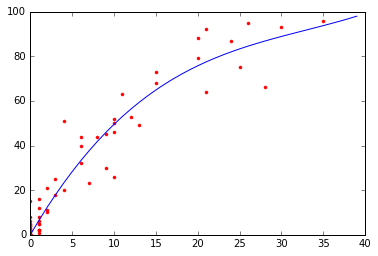

In [45]:
ss3 = lambda theta, x, y: np.sum((y - theta[0] - theta[1]*x - theta[2]*(x**2) 
                                  - theta[3]*(x**3)) ** 2)

bb = pd.read_csv("data/baseball.csv", index_col=0)
plt.plot(bb.hr, bb.rbi, 'r.')
b0,b1,b2,b3 = fmin(ss3, [0,1,-1,0], args=(bb.hr, bb.rbi))
xvals = np.arange(40)
plt.plot(xvals, b0 + b1*xvals + b2*(xvals**2) + b3*(xvals**3))

Of course, we need not fit least squares models by hand. The `statsmodels` package implements least squares models that allow for model fitting in a single line:

In [50]:
import statsmodels

ImportError: No module named 'statsmodels'

In [49]:
import statsmodels.api as sm

straight_line = sm.OLS(y, sm.add_constant(x)).fit()
straight_line.summary()

ImportError: No module named 'statsmodels'

In [48]:
from statsmodels.formula.api import ols as OLS

data = pd.DataFrame(dict(x=x, y=y))
cubic_fit = OLS('y ~ x + I(x**2)', data).fit()

cubic_fit.summary()

ImportError: No module named 'statsmodels'

### Exercise: Polynomial function

Write a function that specified a polynomial of arbitrary degree.

In [47]:
# Write your answer here

## Model Selection

How do we choose among competing models for a given dataset? More parameters are not necessarily better, from the standpoint of model fit. For example, fitting a 9-th order polynomial to the sample data from the above example certainly results in an overfit.

Optimization terminated successfully.
         Current function value: 7.015262
         Iterations: 663
         Function evaluations: 983


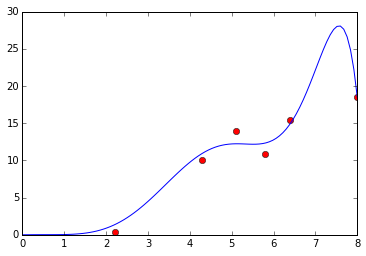

In [48]:
def calc_poly(params, data):
        x = np.c_[[data**i for i in range(len(params))]]
        return np.dot(params, x)
    
ssp = lambda theta, x, y: np.sum((y - calc_poly(theta, x)) ** 2)
betas = fmin(ssp, np.zeros(10), args=(x,y), maxiter=1e6)
plt.plot(x, y, 'ro')
xvals = np.linspace(0, max(x), 100)
plt.plot(xvals, calc_poly(betas, xvals))

One approach is to use an information-theoretic criterion to select the most appropriate model. For example **Akaike's Information Criterion (AIC)** balances the fit of the model (in terms of the likelihood) with the number of parameters required to achieve that fit. We can easily calculate AIC as:

$$AIC = n \log(\hat{\sigma}^2) + 2p$$

where $p$ is the number of parameters in the model and $\hat{\sigma}^2 = RSS/(n-p-1)$.

Notice that as the number of parameters increase, the residual sum of squares goes down, but the second term (a penalty) increases.

To apply AIC to model selection, we choose the model that has the **lowest** AIC value.

In [49]:
n = len(x)

aic = lambda rss, p, n: n * np.log(rss/(n-p-1)) + 2*p

RSS1 = ss(fmin(ss, [0,1], args=(x,y)), x, y)
RSS2 = ss2(fmin(ss2, [1,1,-1], args=(x,y)), x, y)

print aic(RSS1, 2, n), aic(RSS2, 3, n)

Optimization terminated successfully.
         Current function value: 21.375000
         Iterations: 79
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: 14.001110
         Iterations: 198
         Function evaluations: 372
15.7816583572 17.6759368019


Hence, we would select the 2-parameter (linear) model.

## Logistic Regression

Fitting a line to the relationship between two variables using the least squares approach is sensible when the variable we are trying to predict is continuous, but what about when the data are dichotomous?

- male/female
- pass/fail
- died/survived

Let's consider the problem of predicting survival in the Titanic disaster, based on our available information. For example, lets say that we want to predict survival as a function of the fare paid for the journey.

In [50]:
titanic = pd.read_excel("data/titanic.xls", "titanic")
titanic.name

0                      Allen, Miss. Elisabeth Walton
1                     Allison, Master. Hudson Trevor
2                       Allison, Miss. Helen Loraine
3               Allison, Mr. Hudson Joshua Creighton
4    Allison, Mrs. Hudson J C (Bessie Waldo Daniels)
5                                Anderson, Mr. Harry
6                  Andrews, Miss. Kornelia Theodosia
7                             Andrews, Mr. Thomas Jr
8      Appleton, Mrs. Edward Dale (Charlotte Lamson)
9                            Artagaveytia, Mr. Ramon
...
1298                  Wittevrongel, Mr. Camille
1299                        Yasbeck, Mr. Antoni
1300    Yasbeck, Mrs. Antoni (Selini Alexander)
1301                       Youseff, Mr. Gerious
1302                          Yousif, Mr. Wazli
1303                      Yousseff, Mr. Gerious
1304                       Zabour, Miss. Hileni
1305                      Zabour, Miss. Thamine
1306                  Zakarian, Mr. Mapriededer
1307                        Zakari

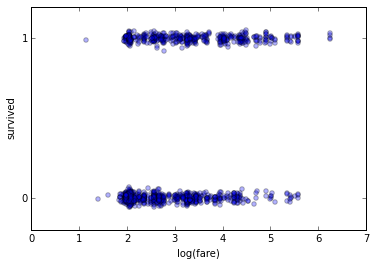

In [51]:
jitter = np.random.normal(scale=0.02, size=len(titanic))
plt.scatter(np.log(titanic.fare), titanic.survived + jitter, alpha=0.3)
plt.yticks([0,1])
plt.ylabel("survived")
plt.xlabel("log(fare)")

I have added random jitter on the y-axis to help visualize the density of the points, and have plotted fare on the log scale.

Clearly, fitting a line through this data makes little sense, for several reasons. First, for most values of the predictor variable, the line would predict values that are not zero or one. Second, it would seem odd to choose least squares (or similar) as a criterion for selecting the best line.

In [52]:
x = np.log(titanic.fare[titanic.fare>0])
y = titanic.survived[titanic.fare>0]
betas_titanic = fmin(ss, [1,1], args=(x,y))

Optimization terminated successfully.
         Current function value: 277.621917
         Iterations: 55
         Function evaluations: 103


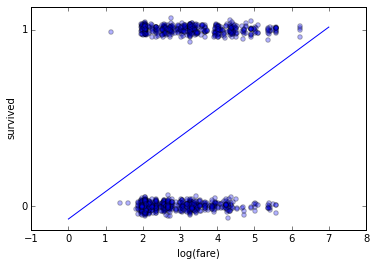

In [53]:
jitter = np.random.normal(scale=0.02, size=len(titanic))
plt.scatter(np.log(titanic.fare), titanic.survived + jitter, alpha=0.3)
plt.yticks([0,1])
plt.ylabel("survived")
plt.xlabel("log(fare)")
plt.plot([0,7], [betas_titanic[0], betas_titanic[0] + betas_titanic[1]*7.])

If we look at this data, we can see that for most values of `fare`, there are some individuals that survived and some that did not. However, notice that the cloud of points is denser on the "survived" (y=1) side for larger values of fare than on the "died" (y=0) side.

### Stochastic model

Rather than model the binary outcome explicitly, it makes sense instead to model the *probability* of death or survival in a **stochastic** model. Probabilities are measured on a continuous [0,1] scale, which may be more amenable for prediction using a regression line. We need to consider a different probability model for this exerciese however; let's consider the **Bernoulli** distribution as a generative model for our data:

<div style="font-size: 120%;">  
$$f(y|p) = p^{y} (1-p)^{1-y}$$ 
</div>  

where $y = \{0,1\}$ and $p \in [0,1]$. So, this model predicts whether $y$ is zero or one as a function of the probability $p$. Notice that when $y=1$, the $1-p$ term disappears, and when $y=0$, the $p$ term disappears.

So, the model we want to fit should look something like this:

<div style="font-size: 120%;">  
$$p_i = \beta_0 + \beta_1 x_i + \epsilon_i$$
</div>

However, since $p$ is constrained to be between zero and one, it is easy to see where a linear (or polynomial) model might predict values outside of this range. We can modify this model sligtly by using a **link function** to transform the probability to have an unbounded range on a new scale. Specifically, we can use a **logit transformation** as our link function:

<div style="font-size: 120%;">  
$$\text{logit}(p) = \log\left[\frac{p}{1-p}\right] = x$$
</div>

Here's a plot of $p/(1-p)$

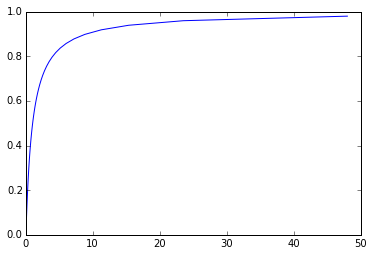

In [54]:
logit = lambda p: np.log(p/(1.-p))
unit_interval = np.linspace(0,1)
plt.plot(unit_interval/(1-unit_interval), unit_interval)

And here's the logit function:

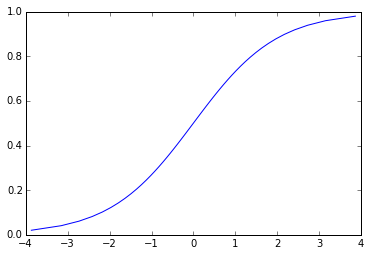

In [55]:
plt.plot(logit(unit_interval), unit_interval)

The inverse of the logit transformation is:

<div style="font-size: 150%;">  
$$p = \frac{1}{1 + \exp(-x)}$$
</div>

So, now our model is:

<div style="font-size: 120%;">  
$$\text{logit}(p_i) = \beta_0 + \beta_1 x_i + \epsilon_i$$
</div>

We can fit this model using maximum likelihood. Our likelihood, again based on the Bernoulli model is:

<div style="font-size: 120%;">  
$$L(y|p) = \prod_{i=1}^n p_i^{y_i} (1-p_i)^{1-y_i}$$
</div>

which, on the log scale is:

<div style="font-size: 120%;">  
$$l(y|p) = \sum_{i=1}^n y_i \log(p_i) + (1-y_i)\log(1-p_i)$$
</div>

We can easily implement this in Python, keeping in mind that `fmin` minimizes, rather than maximizes functions:

In [56]:
invlogit = lambda x: 1. / (1 + np.exp(-x))

def logistic_like(theta, x, y):
    p = invlogit(theta[0] + theta[1] * x)
    # Return negative of log-likelihood
    return -np.sum(y * np.log(p) + (1-y) * np.log(1 - p))

Remove null values from variables

In [57]:
x, y = titanic[titanic.fare.notnull()][['fare', 'survived']].values.T

... and fit the model.

In [58]:
b0,b1 = fmin(logistic_like, [0.5,0], args=(x,y))
b0, b1

Optimization terminated successfully.
         Current function value: 827.015955
         Iterations: 47
         Function evaluations: 93


(-0.88238984528338194, 0.012452067664164127)

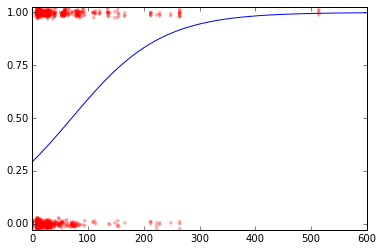

In [59]:
jitter = np.random.normal(scale=0.01, size=len(x))
plt.plot(x, y+jitter, 'r.', alpha=0.3)
plt.yticks([0,.25,.5,.75,1])
xvals = np.linspace(0, 600)
plt.plot(xvals, invlogit(b0+b1*xvals))

As with our least squares model, we can easily fit logistic regression models in `statsmodels`, in this case using the `GLM` (generalized linear model) class with a binomial error distribution specified.

In [60]:
logistic = sm.GLM(y, sm.add_constant(x), family=sm.families.Binomial()).fit()
logistic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 1308
Model:                            GLM   Df Residuals:                     1306
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -827.02
Date:                Wed, 18 Jun 2014   Deviance:                       1654.0
Time:                        20:56:06   Pearson chi2:                 1.33e+03
No. Iterations:                     6                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.8824      0.076    -11.684      0.000        -1.030    -0.734
x1             0.0125      0.002      7.762      0.000         0.009     0.016
==============================================================================
"""

### Exercise: multivariate logistic regression

Which other variables might be relevant for predicting the probability of surviving the Titanic? Generalize the model likelihood to include 2 or 3 other covariates from the dataset.

In [61]:
# Write your answer here

## Bootstrapping

Parametric inference can be **non-robust**:

* inaccurate if parametric assumptions are violated
* if we rely on asymptotic results, we may not achieve an acceptable level of accuracy

Parmetric inference can be **difficult**:

* derivation of sampling distribution may not be possible

An alternative is to estimate the sampling distribution of a statistic *empirically* without making assumptions about the form of the population.

We have seen this already with the kernel density estimate.

### Non-parametric Bootstrap

The bootstrap is a resampling method discovered by [Brad Efron](http://www.jstor.org/discover/10.2307/2958830?uid=3739568&uid=2&uid=4&uid=3739256&sid=21102342537691) that allows one to approximate the true sampling distribution of a dataset, and thereby obtain estimates of the mean and variance of the distribution.

Bootstrap sample:

<div style="font-size: 120%;">  
$$S_1^* = \{x_{11}^*, x_{12}^*, \ldots, x_{1n}^*\}$$
</div>

$S_i^*$ is a sample of size $n$, **with** replacement.

In Python, we have already seen the NumPy function `permutation` that can be used in conjunction with Pandas' `take` method to generate a random sample of some data without replacement:

In [62]:
np.random.permutation(titanic.name)[:5]

array([u'Meek, Mrs. Thomas (Annie Louise Rowley)',
       u'Thorneycroft, Mr. Percival', u'Williams, Mr. Leslie',
       u'Graham, Mr. George Edward', u'Petroff, Mr. Nedelio'], dtype=object)

Similarly, we can use the `random.randint` method to generate a sample *with* replacement, which we can use when bootstrapping.

In [63]:
random_ind = np.random.randint(0, len(titanic), 5)
titanic.name[random_ind]

41      Brown, Mrs. James Joseph (Margaret Tobin)
1061              Nilsson, Miss. Helmina Josefina
937                  Klasen, Miss. Gertrud Emilia
426                            Hale, Mr. Reginald
831                Goodwin, Mr. Charles Frederick
Name: name, dtype: object

We regard S as an "estimate" of population P

> population : sample :: sample : bootstrap sample

The idea is to generate replicate bootstrap samples:

<div style="font-size: 120%;">  
$$S^* = \{S_1^*, S_2^*, \ldots, S_R^*\}$$
</div>

Compute statistic $t$ (estimate) for each bootstrap sample:

<div style="font-size: 120%;">  
$$T_i^* = t(S^*)$$
</div>

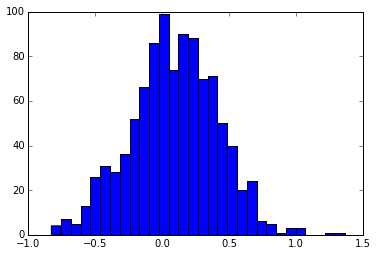

In [64]:
n = 10
R = 1000
# Original sample (n=10)
x = np.random.normal(size=n)
# 1000 bootstrap samples of size 10
s = [x[np.random.randint(0,n,n)].mean() for i in range(R)]
_ = plt.hist(s, bins=30)

### Bootstrap Estimates

From our bootstrapped samples, we can extract *estimates* of the expectation and its variance:

$$\bar{T}^* = \hat{E}(T^*) = \frac{\sum_i T_i^*}{R}$$

$$\hat{\text{Var}}(T^*) = \frac{\sum_i (T_i^* - \bar{T}^*)^2}{R-1}$$


In [65]:
boot_mean = np.sum(s)/R
boot_mean

0.087385394806476724

In [66]:
boot_var = ((np.array(s) - boot_mean) ** 2).sum() / (R-1)
boot_var

0.10590407752057245

Since we have estimated the expectation of the bootstrapped statistics, we can estimate the **bias** of T:

$$\hat{B}^* = \bar{T}^* - T$$


In [67]:
boot_mean - np.mean(x)

-0.00528084680355842

### Bootstrap error

There are two sources of error in bootstrap estimates:

1. **Sampling error** from the selection of $S$.
2. **Bootstrap error** from failing to enumerate all possible bootstrap samples.

For the sake of accuracy, it is prudent to choose at least R=1000

### Bootstrap Percentile Intervals

An attractive feature of bootstrap statistics is the ease with which you can obtain an estimate of *uncertainty* for a given statistic. We simply use the empirical quantiles of the bootstrapped statistics to obtain percentiles corresponding to a confidence interval of interest.

This employs the *ordered* bootstrap replicates:

$$T_{(1)}^*, T_{(2)}^*, \ldots, T_{(R)}^*$$

Simply extract the $100(\alpha/2)$ and $100(1-\alpha/2)$ percentiles:

$$T_{[(R+1)\alpha/2]}^* \lt \theta \lt T_{[(R+1)(1-\alpha/2)]}^*$$

In [68]:
s_sorted = np.sort(s)
s_sorted[:10]

array([-0.82890714, -0.77634577, -0.76588512, -0.76230089, -0.75578488,
       -0.73850118, -0.72869116, -0.72862786, -0.72840095, -0.71831374])

In [69]:
s_sorted[-10:]

array([ 0.81823418,  0.86179331,  0.92314175,  0.93496722,  0.9358216 ,
        1.02058937,  1.03085586,  1.03121927,  1.22699691,  1.3599996 ])

In [70]:
alpha = 0.05
s_sorted[[(R+1)*alpha/2, (R+1)*(1-alpha/2)]]

array([-0.5684053 ,  0.68682205])

### Exercise: Cervical dystonia bootstrap estimates

Use bootstrapping to estimate the mean of one of the treatment groups, and calculate percentile intervals for the mean.

In [71]:
# Write your answer here